---
title: "Newton's Method for Logistic Regression"
author: 'Andre Xiao'
date: '2024-05-02'
image: 'newton.png'
description: "Implementing and experimenting with Newton's method for logistic regression."
format: html
code-annotations: hover
number-sections: true
---

![A comparison of Newton's method (red) and gradient descent (green). Image source: https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Newton_optimization_vs_grad_descent.svg/440px-Newton_optimization_vs_grad_descent.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Newton_optimization_vs_grad_descent.svg/440px-Newton_optimization_vs_grad_descent.svg.png)

Referenced Code: [logistic.py](https://github.com/andrexiao85/andrexiao85.github.io/blob/main/posts/newton_post/logistic.py)

## Abstract

In this blog post, I implement logistic regression using Newton's method. I then perform the following experiments:

1. When the learning rate $\alpha$ is chosen appropriately, Newton's method converges to the correct choice of $\mathbf{w}$. I do this by comparing the result to logistic regression using gradient descent.
2. Under at least some circumstances, Newton's method can converge much faster than standard gradient descent in minimizing empirical risk.
3. If $\alpha$ is too large, Newton's method fails to converge.

Following these experiments, I also analyze the operations needed to perform logistic regression using Newton's method.

## Newton's Method

Newton's method attempts to find the root of a differentiable function $f(x)$. As such, Newton's method can be applied to the derivative of a twice differentiable function $f$ to find the roots of $f'(x)$, or in other words, it can be used to find the critical points of $f$. In optimization, it aims to find the global minima of a function $f$. It does so by using the quadratic Taylor approximation of $f$ for each iterate $x_k$:
$$
f(x) = f(x_k) + f'(x_k)(x-x_k) + \frac{1}{2}f''(x_k)(x-x_k)^2 
$$
If the second derivative is positive, the quadratic approximation is a convex function of $x$ and its minimum can be found by setting the derivative to zero. So,
$$\begin{aligned}
        0 &= \frac{d}{dx}\left(f(x_k)+f'(x_k)(x-x_k)+\frac{1}{2}f''(x_k)(x-x_k)^2\right) \\
        &= f'(x_k) + f''(x_k)(x-x_k)
\end{aligned}
$$

This is essentially the tangent line of $f'$ at point $(x_k, f'(x_k))$ with root $x=x_{k+1}$. Similarly to regular Newton's method, $x_{k+1}$ should be nearly equal to the root of $f'$. Then,
$$
    \begin{align}
        f'(x_k)+f''(x_k)(x_{k+1}-x_k) &= 0 \\
        x_{k+1}-x_k &= -\frac{f'(x_k)}{f''(x_k)} \\
        x_{k+1} &= x_k - \frac{f'(x_k)}{f''(x_k)}.
    \end{align}
$${#eq-newton-update}

We can apply Newton's method for multivariate functions to solve logistic regression. Newton's method for multivariate functions is similar to Newton's method for univariate functions. Using Equation @eq-newton-update as reference, we replace $f'(x)$ with the gradient of $f$ denoted $\nabla f(\mathbf{x})$ and we replace $f''(x)$ with the inverse of the Hessian matrix of $f$ denoted $H^{-1}(\mathbf{x})$. 

The gradient $\nabla f(\mathbf{x})$ is the vector of all the partial derivatives of $f(\mathbf{x})$,
$$
    \nabla f(\mathbf{x}) = 
    \begin{bmatrix}
        \frac{\partial f}{\partial x_1} \\ 
        \frac{\partial f}{\partial x_2} \\ 
        \vdots \\ 
        \frac{\partial f}{\partial x_n} \\ 
    \end{bmatrix}\;.
$$

The Hessian $H(\mathbf{x})$ is the matrix of the second partial derivatives of $f(\mathbf{x})$,
$$
    H(\mathbf{x}) = 
    \begin{bmatrix}
        \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1\partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1\partial x_n}\\ 
        \frac{\partial^2 f}{\partial x_2\partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2\partial x_n}\\ 
        \vdots & \vdots & \ddots & \vdots\\ 
        \frac{\partial^2 f}{\partial x_n\partial x_1} & \frac{\partial^2 f}{\partial x_n\partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}\\ 
    \end{bmatrix}\;.
$$


Applying this to the empirical risk minimization problem:
$$  \DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
        \hat{\mathbf{w}} &= \argmin_{\mathbf{w}} L(\mathbf{w})  \\ 
        &= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(s_i, y_i) \\ 
        &= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \mathbf{x}_i\rangle, y_i)\;.
    \end{aligned}, $$ 
we get
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - H(\mathbf{w}_k)^{-1}\nabla L(\mathbf{w}_k)\;.
$$

### Implementation in Python

```python
def loss(self, X, y):
    s = self.score(X)
    sigma = torch.sigmoid(s) #1/(1+torch.exp(-s))
    return (-y*torch.log(sigma) - (1-y)*torch.log(1 - sigma)).mean()

def grad(self, X, y):
    s = self.score(X)
    sigma = torch.sigmoid(s) #1/(1+torch.exp(-s))
    sigma_y = sigma - y
    return (sigma_y[:, None] * X).mean(0)

def hessian(self, X):
    s = self.score(X)
    sigma = torch.sigmoid(s)
    D = (sigma*(1-sigma)).diag()
    return torch.t(X)@D@X

def step(self, X, y, alpha = 0.01):
    self.model.w -= alpha * torch.linalg.inv(self.model.hessian(X))@self.model.grad(X, y)
```

## Experiments

In [187]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, NewtonOptimizer, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Below, I define some functions to help visualize my data and findings.

In [188]:
import torch
import matplotlib.pyplot as plt

def classification_data(n_points = 300, noise = 0.2, p_dims = 2): # <1>
    
    y = torch.arange(n_points) >= int(n_points/2) # <1>
    y = 1.0*y # <1>
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims)) # <1>
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # <1>
    
    return X, y # <1>

def plot_classification_data(X, y, ax): # <2>
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2." # <2>
    targets = [0, 1] # <2>
    markers = ["o" , ","] # <2>
    for i in range(2): # <2>
        ix = y == targets[i] # <2>
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i]) # <2>
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$") # <2>

def draw_line(w, x_min, x_max, ax, **kwargs): # <3>
    w_ = w.flatten() # <3>
    x = torch.linspace(x_min, x_max, 101) # <3>
    y = -(w_[0]*x + w_[2])/w_[1] # <3>
    l = ax.plot(x, y, **kwargs) # <3>

def train_newton(model, X, y, alpha = 0.01, iters = 100):
    opt = NewtonOptimizer(model) # <4>

    torch.manual_seed(1) # <5>
    #model.loss(X, y) # <5>

    loss_vec = [] # <6>

    for _ in range(iters):
        loss = model.loss(X, y) 
        loss_vec.append(loss)
        opt.step(X, y, alpha)

    return loss_vec

def train_grad(model, X, y, alpha = 0.01, beta = 0, iters = 100):
    opt = GradientDescentOptimizer(model) # <4>

    torch.manual_seed(1) # <5>
    #model.loss(X, y) # <5>

    loss_vec = [] # <6>

    for _ in range(iters):
        loss = model.loss(X, y) # <7>
        loss_vec.append(loss)
        opt.step(X, y, alpha = alpha, beta = beta) # <8>

    return loss_vec

1. Creates data for classification.
2. Plots data.
3. Draws decision boundary.
4. Initializes logistic regression.
5. Set seed for reproducible results.
6. Initialize for tracking.
7. Tracks progress.
8. Updates weight vector $\mathbf{w}$.

### Newton's Method Works

I will show that Newton's method works given a small enough $\alpha$ by comparing it to standard gradient descent.

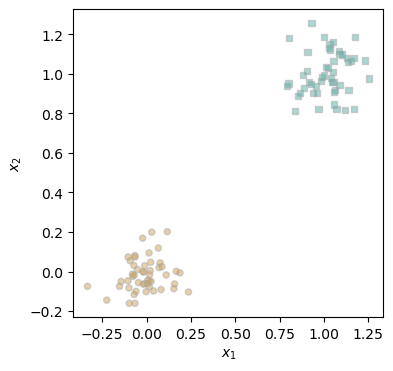

In [189]:
#| code-fold: true
#| fig-cap: 300 data points with `noise = 0.5` in 2 dimensions.
#| label: fig-data

torch.manual_seed(1)
X, y = classification_data(n_points=100, noise = 0.1)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)

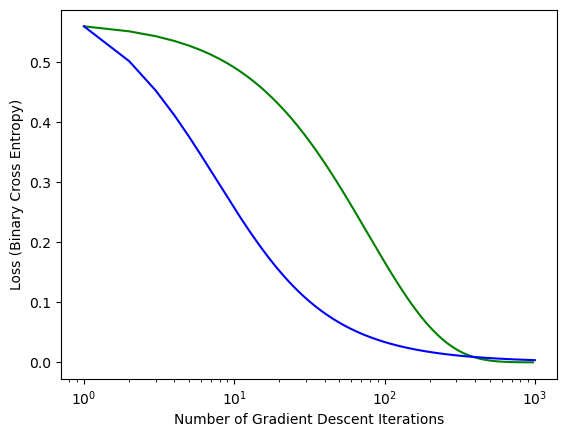

In [194]:
#| code-fold: true
#| fig-cap: Vanilla gradient descent converges to a weight vector $\mathbf{w}$.
#| fig-subcap:
#|  - Loss over iterations.
#|  - Decision boundaries.
#| label: fig-newton

LR1 = LogisticRegression()
loss_vec_newton = train_newton(LR1, X, y, alpha = 1, iters = 1000)

LR2 = LogisticRegression()
loss_vec_grad = train_grad(LR2, X, y, alpha = 1, beta = 0, iters = 1000)

plt.plot(torch.arange(1, len(loss_vec_newton)+1), loss_vec_newton, color = "green")
plt.plot(torch.arange(1, len(loss_vec_grad)+1), loss_vec_grad, color='blue')
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)");

From @fig-newton, we can see that Newton's method works for a sufficiently small $\alpha$ and converges to the same minimal empirical risk as standard gradient descent.

### Newton's Method Can Converge Faster

I'll show that Newton's method can converge faster than standard gradient descent under certain circumstances. In this case, I set `n_points=10` and `noise=0.9`.

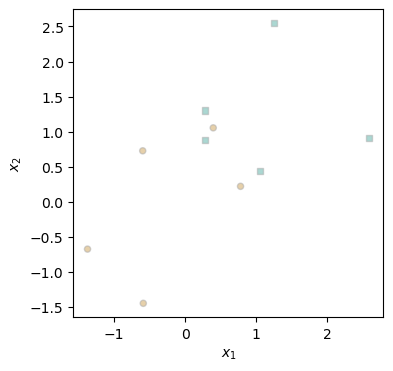

In [195]:
#| code-fold: true
#| fig-cap: 10 data points with `noise = 0.9` in 2 dimensions.
#| label: fig-data2

torch.manual_seed(1)
X, y = classification_data(n_points=10, noise = 0.9)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)

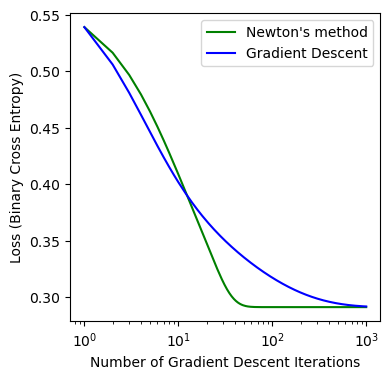

In [199]:
#| fig-cap: Vanilla gradient descent converges to a weight vector $\mathbf{w}$.
#| fig-subcap:
#|  - Loss over iterations.
#|  - Decision boundaries.
#| label: fig-faster

LR3 = LogisticRegression()
loss_vec_newton = train_newton(LR3, X, y, alpha = 0.9, iters = 1000)

LR4 = LogisticRegression()
loss_vec_grad = train_grad(LR4, X, y, alpha = 0.9, beta = 0, iters = 1000)

plt.figure(figsize = (4, 4))
plt.plot(torch.arange(1, len(loss_vec_newton)+1), loss_vec_newton, color = "green", label="Newton's method")
plt.plot(torch.arange(1, len(loss_vec_grad)+1), loss_vec_grad, color='blue', label="Gradient Descent")
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)");
plt.legend();

From @fig-faster, we can see that when there are very few data points and a lot of noise, then Newton's method will converge faster than standard gradient descent.

### Newton's Method Might Not Converge

If $\alpha$ is too large, then Newton's method might not converge. In this case, I use `alpha=20`.

In [200]:
LR4 = LogisticRegression()
loss_vec_newton = train_newton(LR4, X, y, alpha = 20, iters = 1000)

plt.figure(figsize = (4, 4))
plt.plot(torch.arange(1, len(loss_vec_newton)+1), loss_vec_newton, color = "green")
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)");

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/andrexiao/anaconda3/envs/ml-0451/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_49805/3982134260.py", line 2, in <module>
    loss_vec_newton = train_newton(LR4, X, y, alpha = 20, iters = 1000)
  File "/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_49805/1698099668.py", line 39, in train_newton
    opt.step(X, y, alpha)
  File "/Users/andrexiao/Documents/Spring 2024/Machine Learning/Projects/logistic.py", line 112, in step
    self.model.w -= alpha * torch.linalg.inv(self.model.hessian(X))@self.model.grad(X, y)
torch._C._LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users

As we can see, Newton's method fails to converge when $\alpha$ is much greater than the number of data points and we get exceptions. This is because, $H(\mathbf(w))^{-1}$ results in extremely large absolute values, which, when multiplied by a high $alpha$, are incorporated into the weights. As a result, the weights increase significantly with each iteration. This leads to exceedingly high scores, which then become extremely low when calculating $\log(1-\sigma(s))$ which are then interpreted as negative infinity. Running calculations with these `-inf` values ultimately results in `NaNs`.

## Operation Counting

We are given that it costs $c$ computational units to compute loss $L$ and:

- $\nabla L = 2c$
- $H(\mathbf{w}) = pc$
- Invert a $p \times p$ matrix $= k_1p^\gamma$
- Matrix-vector multiplication $= k_2p^2$
- Newton's method converges in $t_{nm}$ steps
- Gradient descent converges in $t_{gd}$ steps

We want to find the total computational costs of Newton's method compared to gradient descent and how much smaller $t_{nm}$ must be compared to $t_{gd}$ for Newton's method to  require fewere computational units to complete? Additioanlly, we want to answer the question: when $p$ becomes very large, is using Newton's method ever going to pay off?

We can do this by first calculating the computational costs of Newton's method and gradient decent.

For Newton's method, we must calculate:

1. $L = c$.
2. $\nabla L = 2c$.
3. $H = pc$.
4. $H^{-1} = k_1p^\gamma$.
5. $H^{-1}L = k_2p^2$.
6. $t_{nm}$ steps $\implies t_{nm}(c+2c+pc+k_1p^\gamma+k_2p^2) = t_{nm}(3c+pc+k_1p^\gamma+k_2p^2)$ total computational units.

For gradient descent, we must calculate:

1. $L = c$.
2. $\nabla L = 2c$.
3. $t_{gd}$ steps $\implies t_{gd}(c+2c) = t_{nm}(3c)$ total computational units.

Then, if we set them equal to each other we can see if Newton's method is worth using when $p$ becomes very large.

$$\begin{aligned}
t_{nm}(3c+pc+k_1p^\gamma+k_2p^2) &= t_{gd}(3c) \\
t_{nm} &= \frac{3c}{3c+pc+k_1p^\gamma+k_2p^2}t_{gd}
\end{aligned}$$

We can see that if $p$ increases, $t_{nm}$ becomes a much smaller percentage than $t_{gd}$ which implies that it is most likely the case that Newton's method is not worth using when $p$ becomes large since it is unlikely that Newton's method converges that much faster than gradient descent.

## Conclusion

Newton's method is an iterative algorithm for rootfinding and can be applied to the derivative of a twice-differentiable function for optimization. As a result, it can be used for solving logistic regression. From the above experiments, we can see that Newton's method works if $\alpha$ is small enough, converges faster than gradient descent when `n_points` is small and `noise` is large, and doesn't converge if $\alpha$ is too large. Additionally, I found that Newton's method is computationally much more expensive than gradient descent and works best for datasets that have few features. When the number of features $p$ increases, Newton's method becomes less likely to be worth using than gradient descent.